In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os

#open csv
filepath = os.path.join('..', 'Database', 'TBIMSPublic.2024-11-01', 'Data', 'Form2.csv')

df = pd.read_csv(filepath)

C:\Users\benol\AppData\Local\Temp\ipykernel_35220\2752882984.py:10: DtypeWarning: Columns (5,6,49,52,53) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)


In [53]:
#inspect
df.info()
print(df.notnull().sum())
df.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75322 entries, 0 to 75321
Columns: 312 entries, Mod2Id to LastValidFollowupYN
dtypes: float64(283), int64(21), object(8)
memory usage: 179.3+ MB
Mod2Id                    75322
Mod1Id                    75322
FollowUpPeriod            75322
IntStatus                 75322
LostReasonF               29686
                          ...  
SRScalF                   75322
SWLSTOT4F                 55109
SWLSTOTF                  55109
WordRecallCorrectF_i_n     9635
LastValidFollowupYN       75322
Length: 312, dtype: int64


,Mod2Id,Mod1Id,FollowUpPeriod,IntStatus,LostReasonF,DeathCause1F,DeathCause2F,DeathECodeF,ResF,LivWhoF,...,PROBLEMUseF,ReasonCorrectF_i_n,REHOSPF,RURALF,SRScal2F,SRScalF,SWLSTOT4F,SWLSTOTF,WordRecallCorrectF_i_n,LastValidFollowupYN
count,75322.000000,75322.000000,75322.000000,75322.000000,29686.000000,75033.0,75031.0,75032,56244.000000,55445.000000,...,55109.000000,9284.000000,55034.000000,50006.000000,44804.000000,75322.000000,55109.000000,55109.000000,9635.000000,75322.000000
unique,NaN,NaN,NaN,NaN,NaN,522.0,410.0,152,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,88888.0,88888.0,88888,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,55473.0,58305.0,63659,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,41989.310029,9287.887364,5.447426,1.813229,61.356599,NaN,NaN,NaN,3.829528,2.989251,...,30.693843,-0.326130,3.855344,2.027397,67.440541,44.732110,241.825310,254.635559,-0.860427,0.161268
std,28938.192670,5819.112238,5.424770,1.742580,39.350327,NaN,NaN,NaN,50.779012,7.460544,...,45.276058,1.093492,18.572278,0.773660,218.304150,47.712379,392.382247,397.307055,1.213544,0.367780
min,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,1.000000,1.000000,...,0.000000,-3.022400,0.000000,1.000000,2.000000,1.000000,4.000000,5.000000,-3.930900,0.000000
25%,18845.250000,4473.000000,1.000000,1.000000,2.000000,NaN,NaN,NaN,1.000000,2.000000,...,0.000000,-1.221500,0.000000,1.000000,2.000000,1.000000,15.000000,18.000000,-1.564100,0.000000
50%,37697.500000,9055.000000,3.000000,1.000000,88.000000,NaN,NaN,NaN,1.000000,2.000000,...,1.000000,-0.454700,0.000000,2.000000,2.000000,3.000000,22.000000,27.000000,-0.830500,0.000000
75%,56547.750000,13528.000000,10.000000,2.000000,88.000000,NaN,NaN,NaN,1.000000,3.000000,...,99.000000,0.493100,1.000000,3.000000,5.000000,99.000000,28.000000,888.000000,-0.062400,0.000000


In [54]:
#inspect mixed columns index
mixed_type_col = [15,6,49,52,53]

#find column names
mixed_type_col_names =[df.columns[column] for column in mixed_type_col]

print(mixed_type_col_names)
print(df['DeathCause2F'].value_counts(dropna=False))


['PRTSchoolF', 'DeathCause2F', 'Rehosp1lv2F', 'Rehosp4lv2F', 'Rehosp5lv2F']
DeathCause2F
88888.0    58305
99999.0     9120
88888       4237
99999       1228
44444.0      513
           ...  
402.91         1
701.0          1
038.9          1
429.2          1
C34.90         1
Name: count, Length: 411, dtype: int64


In [55]:
form_vars_filepath = os.path.join('..', 'Database', 'TBIMSPublic.2024-11-01', 'Code', 'Form2_Variables.csv')
form_vars_df = pd.read_csv(form_vars_filepath)
form_vars_df['Name']

0                      Mod2Id
1                      Mod1Id
2              FollowUpPeriod
3                   IntStatus
4                 LostReasonF
                ...          
307                   SRScalF
308                 SWLSTOT4F
309                  SWLSTOTF
310    WordRecallCorrectF_i_n
311       LastValidFollowupYN
Name: Name, Length: 312, dtype: object

In [56]:
var_codes_filepath = os.path.join('..', 'Database', 'TBIMSPublic.2024-11-01', 'Code', 'Form2_Codes.csv')


df_var_codes = pd.read_csv(var_codes_filepath)

var_labels_dict ={}
for var in df_var_codes['VariableName'].unique():
    sub_df = df_var_codes[df_var_codes["VariableName"] == var]
    value_map = dict(zip(sub_df['Code'], sub_df['CodeDescription']))
    var_labels_dict[var] = value_map

In [57]:
df.dtypes.value_counts()

float64    283
int64       21
object       8
Name: count, dtype: int64

In [58]:
def normalize_code(code):
    """ will convert to format 'string.0' """
    #try to convert to a float directly
    try:
        return str(float(code))
    #if it can't be converted to a float, save it as a string
    except ValueError:
        return str(code)

def process_mixed_variables(df, value_labels_dict, replace_col=False, code_col=False, code_label_col=False,errors="coerece"):
    """
    Cleans coded categorical/numeric variables using a value label dict.
    Returns a cleaned dataframe and a summary.
    """
    df = df.copy()
    original_cols = df.columns
    col_map = {col.lower(): col for col in original_cols}

    new_columns = {}
    summary_list = []


    for var_raw, codes_dict in value_labels_dict.items():
        var_lower = var_raw.lower()

        if var_lower not in col_map:
            continue

        original_var = col_map[var_lower]

        # Work on a lowercase temporary series for logic
        temp_series = df[original_var].copy()

        # Normalize for mapping
        code_keys = set(normalize_code(k) for k in codes_dict.keys())

        # Convert entries for numeric masking
        temp_series = temp_series.apply(lambda x: str(float(x)) if pd.notna(x) and str(x).replace('.', '', 1).isdigit() else x)
        clean_series = pd.to_numeric(temp_series.mask(temp_series.isin(code_keys)), errors=errors)

        mapped_dict = {str(float(k)) if k.isdigit() else k: v for k, v in codes_dict.items()}
        label_series = temp_series.map(mapped_dict)

        # Output columns using original name
        if replace_col:
            new_columns[original_var] = clean_series
        else:
            new_columns[f'{original_var}_clean'] = clean_series

        if code_col:
            new_columns[f'{original_var}_code'] = temp_series.where(temp_series.isin(code_keys))
        
        if code_label_col:
            new_columns[f'{original_var}_code_label'] = label_series

        summary = {
            "Variable": original_var,
            "Valid Count": clean_series.count(),
            "Mean": clean_series.mean(),
            "Std Dev": clean_series.std(),
            "all_categorical": clean_series.isna().all()
        }

        summary.update(label_series.value_counts().to_dict())
        summary_list.append(summary)
    

    # Drop old versions of columns being replaced
    df = df.drop(columns=new_columns.keys(), errors='ignore')
    df = pd.concat([df, pd.DataFrame(new_columns)], axis=1)
    summary_df = pd.DataFrame(summary_list).infer_objects(copy=False)

    return df, summary_df

In [59]:
df_decoded, summary = process_mixed_variables(df, var_labels_dict, replace_col=True,code_col=True,code_label_col=True,errors="coerce")





In [116]:
def find_col_by_variable(df, value):
    cols = []

    for col in df.columns:
        if (df[col] ==value).any():
            cols.append(col)
    return cols

weird_col = find_col_by_variable(df_decoded, 'PI_Original')

col_map = {col.lower(): col for col in df.columns} 

categorical_cols = summary[summary['all_categorical'] == True]['Variable'].str.lower().str.strip().tolist()

continuous_cols = [
    i.lower().strip()
    for i in form_vars_df['Name'].unique()
    if i.lower().strip() not in categorical_cols
]

continuous_cols = list(map(col_map.get, continuous_cols))
categorical_cols = list(map(col_map.get, categorical_cols))

categorical_cols += weird_col
continuous_cols.remove(weird_col[0])

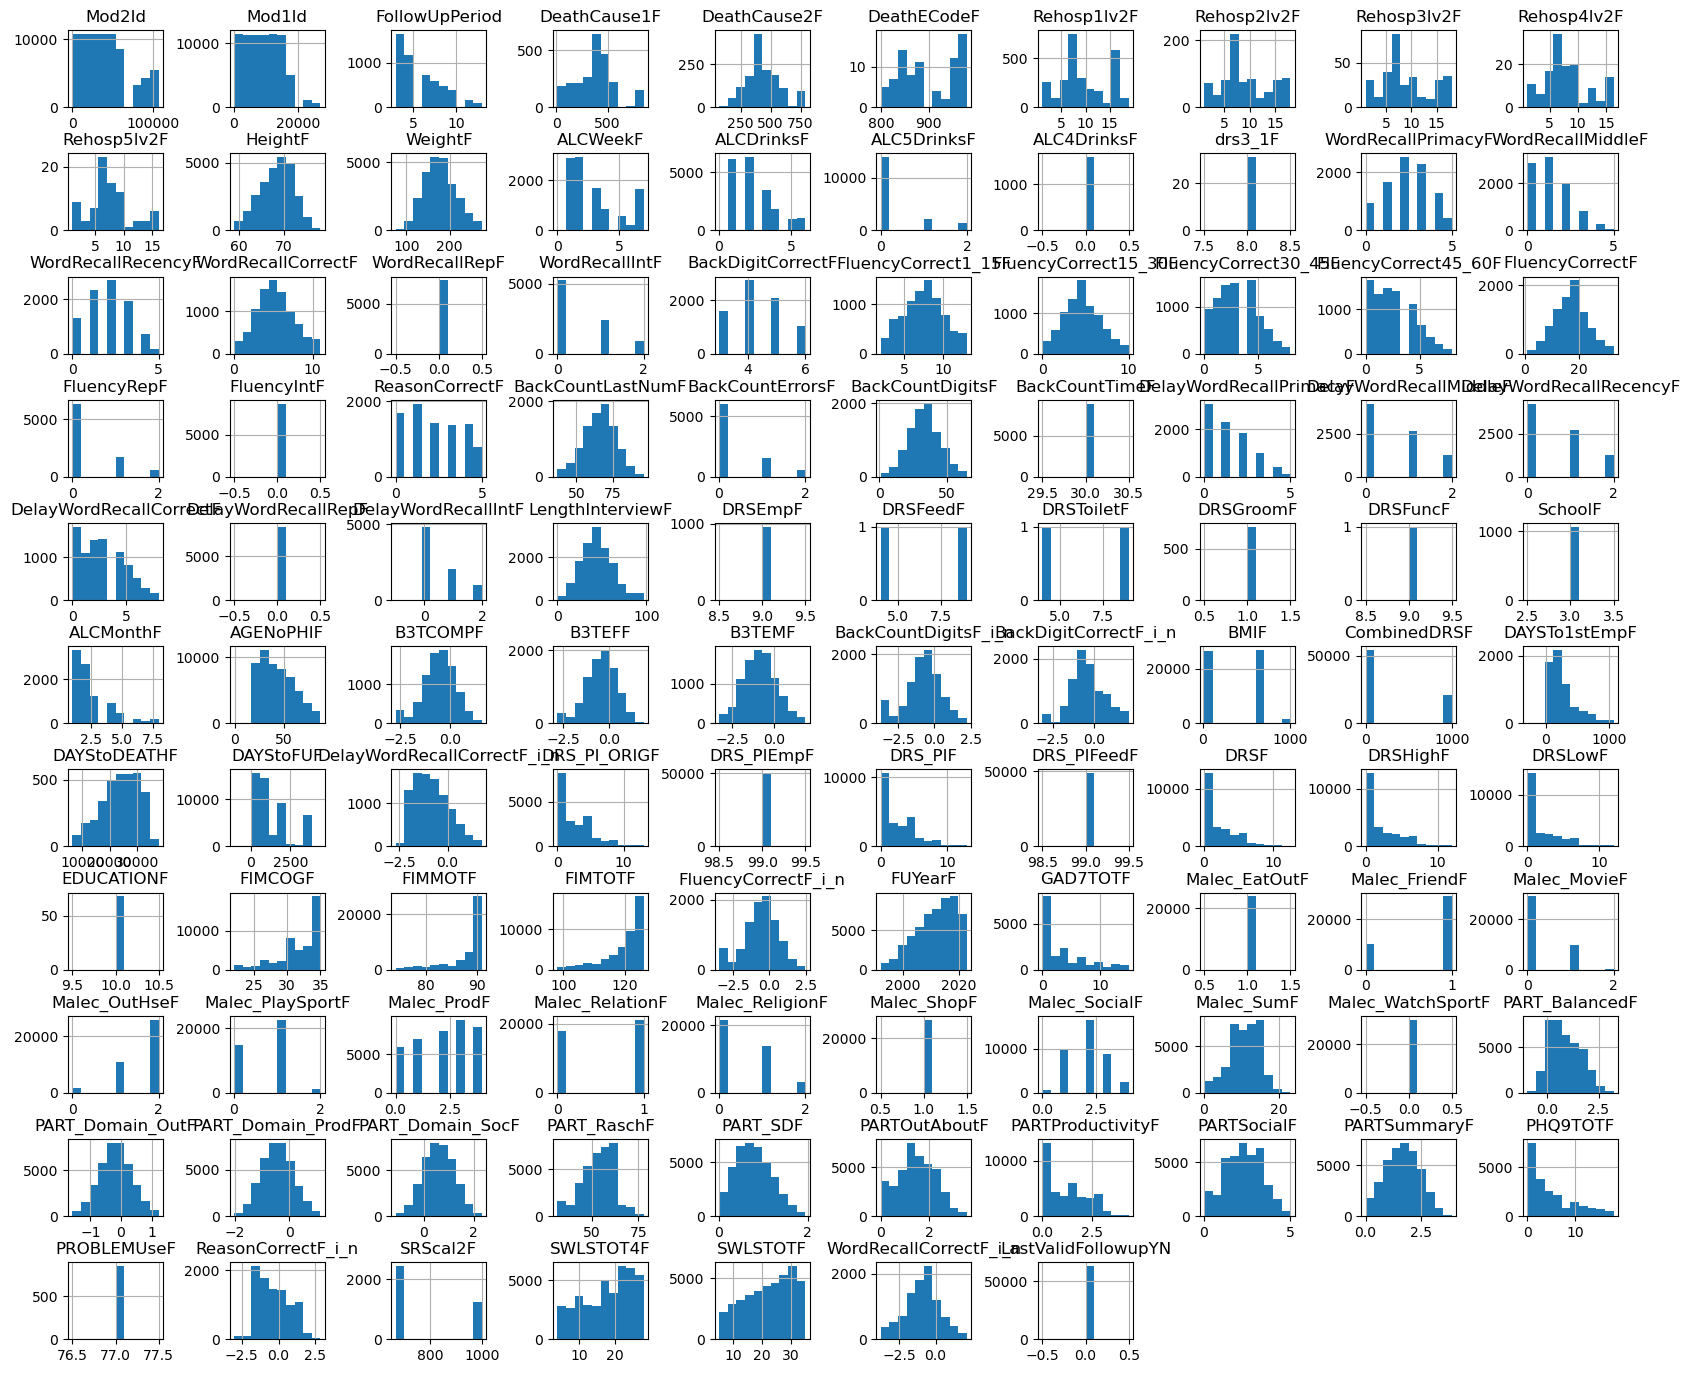

In [88]:
#Compute IQR

data = df_decoded[continuous_cols].astype(float)


Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

# Define bounds (you can adjust the multiplier)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
filtered_data = data[(data >= lower_bound) & (data <= upper_bound)]



# Plot histogram

ax = filtered_data.hist(figsize=(20, 17))

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.6, wspace=0.7)
plt.title("Histogram (Outliers Removed)")
plt.show()

In [117]:
#id are records
record_columns = ['Mod1Id', 'Mod2Id']
var_labels_dict['record_columns'] = record_columns

#these are categorical ordinal
more_categories = [
'Rehosp1lv2F',
'Rehosp2lv2F',
'Rehosp3lv2F',
'Rehosp4lv2F',
'Rehosp5lv2F',
"ReasonCorrectF",
'ALCWeekF',
'DeathCause1F',
'DeathCause2F',
'DeathECodeF'
]

categorical_cols += more_categories

#FollowUpPeriod is a weird one because according to the provided codes, you might assume it is categorical
# looking the data it is continuous

#drs3_1F has unknown code 8, categorical. Assuming it was 88
cat_non_value_codes = {}

drs3_1F = {"8" : 'Not Applicable'}
cat_non_value_codes['drs3_1F'] = drs3_1F
categorical_cols.append('drs3_1F')

#WordRecallRepF has a negative value


#WordRecallIntF has negative values and a code 88
WordRecallIntF = {"88" : 'Not Applicable'}
var_labels_dict['WordRecallIntF'] = WordRecallIntF

#FluencyCorrect45_60F has a code 6666
FluencyCorrect45_60F = {"6666" : 'Variable Did Not Exist'}
var_labels_dict['FluencyCorrect45_60F'] = FluencyCorrect45_60F


#FluencyRepF has negative values

#FluencyIntF has negative values, possibly code 88
FluencyIntF = {"88" : 'Not Applicable'}
var_labels_dict['FluencyIntF'] = FluencyIntF


#DelayWordRecallIntF has negative values 

#DRSEmpF has a code 9, encoded as 9.9 in form2_codes.csv, categorical
DRSEmpF = {"9" : 'Unknown',
           '9.9' : 'Unknown'}

cat_non_value_codes['DRSEmpF'] = DRSEmpF
categorical_cols.append('DRSEmpF')
continuous_cols.remove('DRSEmpF')


#DRSFeedF, DRSToiletF has a code 4 and 9, categorical
DRSFeedF = {"9" : 'Unknown',
            '4' : np.nan}
cat_non_value_codes['DRSFeedF'] = DRSFeedF
categorical_cols.append('DRSFeedF')
continuous_cols.remove('DRSFeedF')


#DRSGroomF has a code 1 and 9, categorical
#looking at the description, 1 I believe is "partial"

DRSGroomF = {"9" : 'Unknown',
            '1' : 'Partial'}
var_labels_dict['DRSGroomF'] = DRSGroomF
cat_non_value_codes['DRSGroomF'] = {"9" : 'Unknown'}
categorical_cols.append('DRSGroomF')
continuous_cols.remove('DRSGroomF')


#DRSFuncF has a code 9, categorical
DRSFuncF = {"9" : 'Unknown'}
cat_non_value_codes['DRSFuncF'] = DRSFuncF
categorical_cols.append('DRSFuncF')
continuous_cols.remove('DRSFuncF')


#SchoolF has a code 3, categorical
SchoolF = {"3" : 'Non-disclosed primary education'}
var_labels_dict['SchoolF'] = DRSFuncF
categorical_cols.append('SchoolF')
continuous_cols.remove('SchoolF')

#BMIF has a code 666 and 999
BMIF = {"666" : 'Variable Did Not Exist',
            '999' : 'Unknown'}
var_labels_dict['BMIF'] = BMIF


#CombinedDRSF has a code 999
CombinedDRSF = { '999' : 'Partial'}
var_labels_dict['CombinedDRSF'] = CombinedDRSF

#DAYSTo1stEmpF not sure how to handle this one. it has some important codes


#DRS_PIEmpF has code 99, categorical
DRS_PIEmpF = {"99" : 'Unknown'}
cat_non_value_codes['DRS_PIEmpF'] = DRS_PIEmpF
categorical_cols.append('DRS_PIEmpF')
continuous_cols.remove('DRS_PIEmpF')

#DRS_PIFeedF has code 99, is categorical
DRS_PIFeedF = {"99" : 'Unknown'}
cat_non_value_codes['DRS_PIFeedF'] = DRS_PIFeedF
categorical_cols.append('DRS_PIFeedF')
continuous_cols.remove('DRS_PIFeedF')

#DRSF, DRSHighF, DRSLowF have code 777
DRS = ['DRSF', 'DRSHighF', 'DRSLowF']
drs_777 = {"777" : 'Refused'}
for i in DRS:
    var_labels_dict[i] = drs_777

#EDUCATIONF has code 10 and 777, is categorical
#I dont really have a guess as to what 10 was. its non-trivial but not close enough to 1 to be accidental
EDUCATIONF = { '777' : 'Refused'}
cat_non_value_codes['EDUCATIONF'] = EDUCATIONF
categorical_cols.append('EDUCATIONF')
continuous_cols.remove('EDUCATIONF')

#more categorical
Malec = ['Malec_EatOutF',
'Malec_FriendF',
'Malec_MovieF',
'Malec_OutHseF',
'Malec_PlaySportF',
'Malec_ProdF',
'Malec_RelationF',
'Malec_ReligionF',
'Malec_ShopF',
'Malec_SocialF',
'Malec_SumF',
'Malec_WatchSportF']

categorical_cols += Malec

#not sure about these, I think these are summary statistics
part = ['PART_BalancedF',
'PART_Domain_OutF',
'PART_Domain_ProdF',
'PART_Domain_SocF',
'PART_RaschF',
'PART_SDF',
'PARTOutAboutF',
'PARTProductivityF',
'PARTSocialF',
'PARTSummaryF']

#PROBLEMUseF had code 77
PROBLEMUseF = { '77' : 'Refused'}
var_labels_dict['PROBLEMUseF'] = PROBLEMUseF

#ReasonCorrectF is categorical
categorical_cols.append('ReasonCorrectF')
continuous_cols.remove('ReasonCorrectF')

#SRScal2F has codes 666 and 999
SRScal2F = { '666' : 'Variable Did Not Exist',
                '999' : 'Unknown'}
var_labels_dict['SRScal2F'] = SRScal2F


#SWLSTOT4F 888.0 999.0 
SWLSTOT4F = { '888' : 'Not Applicable',
                '999' : 'Unknown'}
var_labels_dict['SWLSTOT4F'] = SWLSTOT4F

#LastValidFollowupYN is boolean 
categorical_cols.append('LastValidFollowupYN')
continuous_cols.remove('LastValidFollowupYN')

#remove negative values 
cols_with_neg = ['WordRecallRepF', 'WordRecallIntF', 'FluencyRepF', 'FluencyIntF', 'DelayWordRecallIntF']
df_decoded[df[cols_with_neg] < 0 ] = np.nan


continuous_cols = [i for i in continuous_cols if i not in categorical_cols]


var_labels_dict['cont_cols'] = continuous_cols
var_labels_dict['cat_cols'] = categorical_cols

In [118]:
print(len(categorical_cols) + len(continuous_cols))
print(len(categorical_cols))
print(len(continuous_cols))

313
238
75


In [119]:
len(df.columns)

312

In [120]:
all_col = continuous_cols + categorical_cols

overlap = [i for i in all_col if i not in df.columns]
print(overlap)

[]


In [121]:
print(continuous_cols)

['Mod2Id', 'Mod1Id', 'FollowUpPeriod', 'HeightF', 'WeightF', 'ALCDrinksF', 'ALC5DrinksF', 'ALC4DrinksF', 'WordRecallPrimacyF', 'WordRecallMiddleF', 'WordRecallRecencyF', 'WordRecallCorrectF', 'WordRecallRepF', 'WordRecallIntF', 'BackDigitCorrectF', 'FluencyCorrect1_15F', 'FluencyCorrect15_30F', 'FluencyCorrect30_45F', 'FluencyCorrect45_60F', 'FluencyCorrectF', 'FluencyRepF', 'FluencyIntF', 'BackCountLastNumF', 'BackCountErrorsF', 'BackCountDigitsF', 'BackCountTimeF', 'DelayWordRecallPrimacyF', 'DelayWordRecallMiddleF', 'DelayWordRecallRecencyF', 'DelayWordRecallCorrectF', 'DelayWordRecallRepF', 'DelayWordRecallIntF', 'LengthInterviewF', 'DRSToiletF', 'ALCMonthF', 'AGENoPHIF', 'B3TCOMPF', 'B3TEFF', 'B3TEMF', 'BackCountDigitsF_i_n', 'BackDigitCorrectF_i_n', 'BMIF', 'CombinedDRSF', 'DAYSTo1stEmpF', 'DAYStoDEATHF', 'DAYStoFUF', 'DelayWordRecallCorrectF_i_n', 'DRS_PI_ORIGF', 'DRS_PIF', 'DRSF', 'DRSHighF', 'DRSLowF', 'FIMCOGF', 'FIMMOTF', 'FIMTOTF', 'FluencyCorrectF_i_n', 'FUYearF', 'GAD7TOT